<a href="https://colab.research.google.com/github/woodstone10/deep_learning_study-python/blob/main/NLP_named_entity_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Named Entity Recognition

# Using NLTK library


---





In [1]:
import nltk
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.


True

## Part of Speech




In [2]:
from nltk import word_tokenize, pos_tag, ne_chunk
sentence = "Jonggil Nam is working at LG Electronics"
sentence = pos_tag(word_tokenize(sentence))
print(sentence)

[('Jonggil', 'NNP'), ('Nam', 'NNP'), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), ('LG', 'NNP'), ('Electronics', 'NNP')]


## Entity name

In [3]:
sentence = ne_chunk(sentence)
print(sentence)

(S
  (PERSON Jonggil/NNP)
  (ORGANIZATION Nam/NNP)
  is/VBZ
  working/VBG
  at/IN
  (ORGANIZATION LG/NNP Electronics/NNP))


# with Deep learning

---



## Train Data

paired word-entity name

https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt


In [4]:
import urllib.request
data = urllib.request.urlopen("https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt").readlines()
data[:10]

[b'-DOCSTART- -X- -X- O\n',
 b'\n',
 b'EU NNP B-NP B-ORG\n',
 b'rejects VBZ B-VP O\n',
 b'German JJ B-NP B-MISC\n',
 b'call NN I-NP O\n',
 b'to TO B-VP O\n',
 b'boycott VB I-VP O\n',
 b'British JJ B-NP B-MISC\n',
 b'lamb NN I-NP O\n']

In [5]:
import urllib.request
tagged_sentences = []
sentence = []
with urllib.request.urlopen("https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt") as file:
  for line in file:
    line = line.decode('utf-8')
    if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
      if len(sentence) > 0:
        tagged_sentences.append(sentence)
        sentence = []
      continue
    splits = line.strip().split(' ')
    word = splits[0].lower()
    sentence.append([word, splits[-1]])

print(len(tagged_sentences))
print(tagged_sentences[0])


14041
[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


In [6]:
sentences, ner_tags = [], []
for tagged_sentence in tagged_sentences:
  sentence, tag_info = zip(*tagged_sentence)
  sentences.append(list(sentence))
  ner_tags.append(list(tag_info))

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
max_words = 4000
src_tokenizer = Tokenizer(num_words=max_words, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [9]:
vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1
print(vocab_size)
print(tag_size)

4000
10


In [10]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len =70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=111)
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8985, 70)
(8985, 70, 10)
(2247, 70)
(2247, 70, 10)


## Model

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from keras.optimizers import Adam
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))
model.summary()
model.compile(optimizer=Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 128)           512000    
_________________________________________________________________
bidirectional (Bidirectional (None, 70, 512)           788480    
_________________________________________________________________
time_distributed (TimeDistri (None, 70, 10)            5130      
Total params: 1,305,610
Trainable params: 1,305,610
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(X_train,
                    y_train, 
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2
                    )

Epoch 1/30
57/57 [==============================] - 2s 30ms/step - loss: 0.0190 - accuracy: 0.9730 - val_loss: 0.0405 - val_accuracy: 0.9447
Epoch 2/30
57/57 [==============================] - 2s 27ms/step - loss: 0.0166 - accuracy: 0.9766 - val_loss: 0.0409 - val_accuracy: 0.9459
Epoch 3/30
57/57 [==============================] - 2s 27ms/step - loss: 0.0149 - accuracy: 0.9793 - val_loss: 0.0420 - val_accuracy: 0.9433
Epoch 4/30
57/57 [==============================] - 2s 27ms/step - loss: 0.0138 - accuracy: 0.9803 - val_loss: 0.0425 - val_accuracy: 0.9434
Epoch 5/30
57/57 [==============================] - 2s 27ms/step - loss: 0.0122 - accuracy: 0.9828 - val_loss: 0.0419 - val_accuracy: 0.9466
Epoch 6/30
57/57 [==============================] - 2s 26ms/step - loss: 0.0105 - accuracy: 0.9854 - val_loss: 0.0445 - val_accuracy: 0.9453
Epoch 7/30
57/57 [==============================] - 2s 26ms/step - loss: 0.0094 - accuracy: 0.9875 - val_loss: 0.0459 - val_accuracy: 0.9438
Epoch 8/30
57

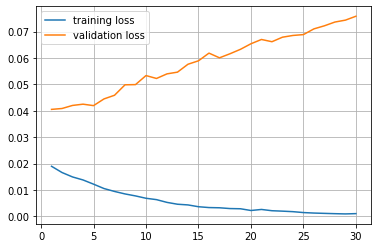

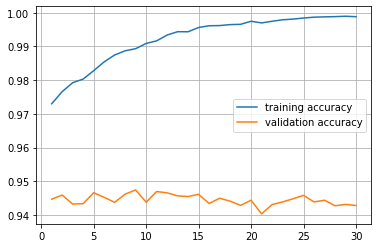

In [30]:
import matplotlib.pyplot as plt
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.legend()
plt.grid()
plt.show()

In [31]:
model.evaluate(X_test, y_test)

71/71 [==============================] - 1s 7ms/step - loss: 0.0734 - accuracy: 0.9455


[0.07335249334573746, 0.9454590082168579]

## Prediction

In [51]:
idx2word = src_tokenizer.index_word
idx2ner = tar_tokenizer.index_word
idx2ner[0] = 'PAD'

In [ ]:
print(idx2word)

In [ ]:
print(idx2ner)

In [59]:
import numpy as np
def ner_predict(i):
  y_pred = model.predict(np.array([X_test[i]]))
  y_pred = np.argmax(y_pred, axis=-1)
  true = np.argmax(y_test[i], -1)
  print("{:15}|{:10}|{}".format("word","real","pred"))
  print("-"*40)
  for w, t, pred in zip(X_test[i], true, y_pred[0]):
    if w != 0:
      print("{:15}|{:10}|{}".format(idx2word[w], idx2ner[t].upper(), idx2ner[pred].upper()))

In [62]:
ner_predict(12)

word           |real      |pred
----------------------------------------
thailand       |B-LOC     |B-LOC
has            |O         |O
launched       |O         |O
a              |O         |O
OOV            |O         |O
for            |O         |O
an             |O         |O
australian     |B-MISC    |B-MISC
who            |O         |O
escaped        |O         |O
from           |O         |O
a              |O         |O
high           |O         |B-LOC
security       |O         |O
prison         |O         |O
in             |O         |O
bangkok        |B-LOC     |B-LOC
while          |O         |O
OOV            |O         |O
trial          |O         |O
on             |O         |O
drug           |O         |O
OOV            |O         |O
charges        |O         |O
,              |O         |O
officials      |O         |O
said           |O         |O
on             |O         |O
thursday       |O         |O
.              |O         |O


In [63]:
ner_predict(64)

word           |real      |pred
----------------------------------------
OOV            |B-PER     |B-PER
OOV            |I-PER     |I-PER
(              |O         |O
slovakia       |B-LOC     |B-LOC
)              |O         |O
beat           |O         |O
6              |O         |O
-              |O         |O
karina         |B-PER     |B-PER
habsudova      |I-PER     |I-PER


In [64]:
ner_predict(119)

word           |real      |pred
----------------------------------------
OOV            |B-ORG     |B-ORG
OOV            |O         |O
in             |O         |O
its            |O         |O
latest         |O         |O
review         |O         |O
OOV            |O         |O
of             |O         |O
OOV            |O         |O
by             |O         |O
OOV            |B-ORG     |B-ORG
corp           |I-ORG     |I-ORG
,              |O         |O
with           |O         |O
cniec          |B-ORG     |B-ORG
said           |O         |O
to             |O         |O
be             |O         |O
OOV            |O         |O
the            |O         |O
japanese       |B-MISC    |B-MISC
trader         |O         |O
OOV            |O         |O
its            |O         |O
copper         |O         |O
positions      |O         |O
after          |O         |O
it             |O         |O
OOV            |O         |O
in             |O         |O
june           |O         |O
losses 